# Checking Fisher Matrix Accuracy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lisatools.sensitivity import get_sensitivity
from lisatools.diagnostic import (
    inner_product,
    snr,
    fisher,
    covariance,
    mismatch_criterion,
    cutler_vallisneri_bias,
    scale_snr,
)
import h5py
import glob
import corner
from few.waveform import FastSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.utils.utility import get_overlap, get_mismatch, get_fundamental_frequencies, get_separatrix, get_mu_at_t, get_p_at_t

from lisatools.sampling.likelihood import Likelihood

from lisatools.sampling.samplers.emcee import EmceeSampler
from lisatools.sampling.samplers.ptemcee import PTEmceeSampler


from lisatools.utils.transform import TransformContainer

import warnings

warnings.filterwarnings("ignore")


use_gpu = False
fast = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux",
    sum_kwargs=dict(pad_output=True),
    use_gpu=use_gpu,
    return_list=True,
)

fast_not_list = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux",
    sum_kwargs=dict(pad_output=True),
    use_gpu=use_gpu,
    return_list=False,
)

/Users/lorenzosperi/Documents/GitHub/LISAanalysistools/lisatools/sensitivity.py:18: UserWarning: No tdi module available.
  warnings.warn("No tdi module available.")


## parameters from file

In [2]:
filenames = glob.glob('/Users/lorenzosperi/Nextcloud/AEI/FEW_paper/corner_data/output_2yr_snr_30*1e-5.h5') #output_2yr_snr_30_no_noise_3000000.0_10.0_0.5_1e-2.h5

traj_module = RunSchwarzEccFluxInspiral()

ind_file = 3
print(filenames[ind_file])
M = float(filenames[ind_file].split('_')[8])
mu = float(filenames[ind_file].split('_')[9])
e0 = float(filenames[ind_file].split('_')[10])
t_out = 0.5
print(M, mu,e0)
traj_args = [M, mu, e0]
traj_kwargs = {}
index_of_p = 2
p0 = get_p_at_t(traj_module, t_out, traj_args)
print('p0 = {} will create a waveform that is {} years long, given the other input parameters.'.format(p0, t_out))



/Users/lorenzosperi/Nextcloud/AEI/FEW_paper/corner_data/output_2yr_snr_30_no_noise_3000000.0_30.0_0.1_1e-5.h5
3000000.0 30.0 0.1
p0 = 8.0 will create a waveform that is 0.5 years long, given the other input parameters.


In [19]:

# define injection parameters
M = 1.00000000e06
mu = 3.00000000e01
p0 = 13.0
e0 = 3.00000000e-01
dist = 4.10864264e00
Phi_phi0 = 3.2302777624860943
Phi_r0 = 4.720221760052107

# define other parameters necessary for calculation
a = 0.0
Y0 = 1.0
qS = 0.5420879369091457
phiS = 5.3576560705195275
qK = 1.7348119514252445
phiK = 3.2004167279159637
Phi_theta0 = 0.0

# injection array
injection_params = np.array(
    [
        np.log(M),
        np.log(mu),
        a,  # will ignore
        p0,
        e0,
        Y0,  # will ignore
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,  # will ignore
        Phi_r0,
    ]
)

# define other quantities
T = 2  # years
dt = 10.0

snr_goal = 30.0

# for SNR and covariance calculation
inner_product_kwargs = dict(dt=dt, PSD="cornish_lisa_psd")

# transformation of arguments from sampling basis to waveform basis
transform_fn_in = {
    0: (lambda x: np.exp(x)),1: (lambda x: np.exp(x)),
}

# use the special transform container
transform_fn = TransformContainer(transform_fn_in)

# copy parameters to check values
check_params = injection_params.copy()

# this transforms but also gives the transpose of the input dimensions due to inner sampler needs
check_params = transform_fn.transform_base_parameters(check_params).T

# INJECTION kwargs
specific_modes = [(2, m, n) for m in range(0,2) for n in range(-10, 11)] #[(2,2,0)]#
waveform_kwargs = {"T": T, "dt": dt, "mode_selection": specific_modes} #"eps": 1e-2} #

check_sig = fast(*check_params, **waveform_kwargs)

# adjust distance for SNR goal
check_sig, snr_orig = scale_snr(snr_goal, check_sig, return_orig_snr=True,**inner_product_kwargs) #, dt=dt

print("orig_dist:", injection_params[6])
injection_params[6] *= snr_orig / snr_goal
print("new_dist:", injection_params[6])

# copy again
params_test = injection_params.copy()

# define sampling quantities
nwalkers = 32  # per temperature
ntemps = 10

ndim_full = 14  # full dimensionality of inputs to waveform model

# which of the injection parameters you actually want to sample over
test_inds = np.array([0, 1, 3, 4, 11, 13]) #np.array([0, 1, 3, 4])

# ndim for sampler
ndim = len(test_inds)

# need to get values to fill arrays for quantities that we are not sampling
fill_inds = np.delete(np.arange(ndim_full), test_inds)
fill_values = injection_params[fill_inds]

# to store in sampler file, get injection points we are sampling
injection_test_points = injection_params[test_inds]

# instantiate the likelihood class
nchannels = 2
like = Likelihood(
    fast, nchannels, dt=dt, parameter_transforms=transform_fn, use_gpu=use_gpu,
)

# inject
like.inject_signal(
    params=injection_params.copy(),
    waveform_kwargs=waveform_kwargs,
    noise_fn=get_sensitivity,
    noise_kwargs=dict(sens_fn="cornish_lisa_psd"),
    add_noise=False,
)


orig_dist: 4.10864264
new_dist: 0.05302073269425042


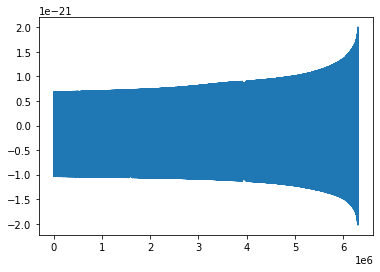

In [20]:
plt.plot(check_sig[0])

## Create fisher matrix

In [21]:
#test_inds = np.array([0, 1, 3, 4])

# get covariance in 3 minutes
eps = 1e-7 #[1e-8, 1e-8, 1e-8, 1e-8, 1e-7, 1e-7]
#for eps in [1e-8, 5e-8, 1e-7, 5e7]:
    
cov, fish, dh = covariance(
    fast_not_list,
    injection_params,
    eps,
    deriv_inds=test_inds,
    parameter_transforms=transform_fn,
    waveform_kwargs=waveform_kwargs,
    inner_product_kwargs=inner_product_kwargs,
    diagonalize=False,
    return_fisher=True,
    return_derivs=True
)

sig_diag = np.sqrt(cov.diagonal())

print(fish)

    

[[ 8.22122306e+14 -2.11917781e+14  1.15188581e+14  2.25344821e+14
  -7.37270233e+08 -9.49389870e+08]
 [-2.11917781e+14  5.73468367e+13 -3.03252292e+13 -5.47797222e+13
   1.86361235e+08  1.98878448e+08]
 [ 1.15188581e+14 -3.03252292e+13  1.63840720e+13  3.08129140e+13
  -1.04385885e+08 -1.20584679e+08]
 [ 2.25344821e+14 -5.47797222e+13  3.08129140e+13  6.61972228e+13
  -2.11063766e+08 -3.20486962e+08]
 [-7.37270233e+08  1.86361235e+08 -1.04385885e+08 -2.11063766e+08
   8.89243420e+02  8.16313484e+02]
 [-9.49389870e+08  1.98878448e+08 -1.20584679e+08 -3.20486962e+08
   8.16313484e+02  2.41756219e+03]]


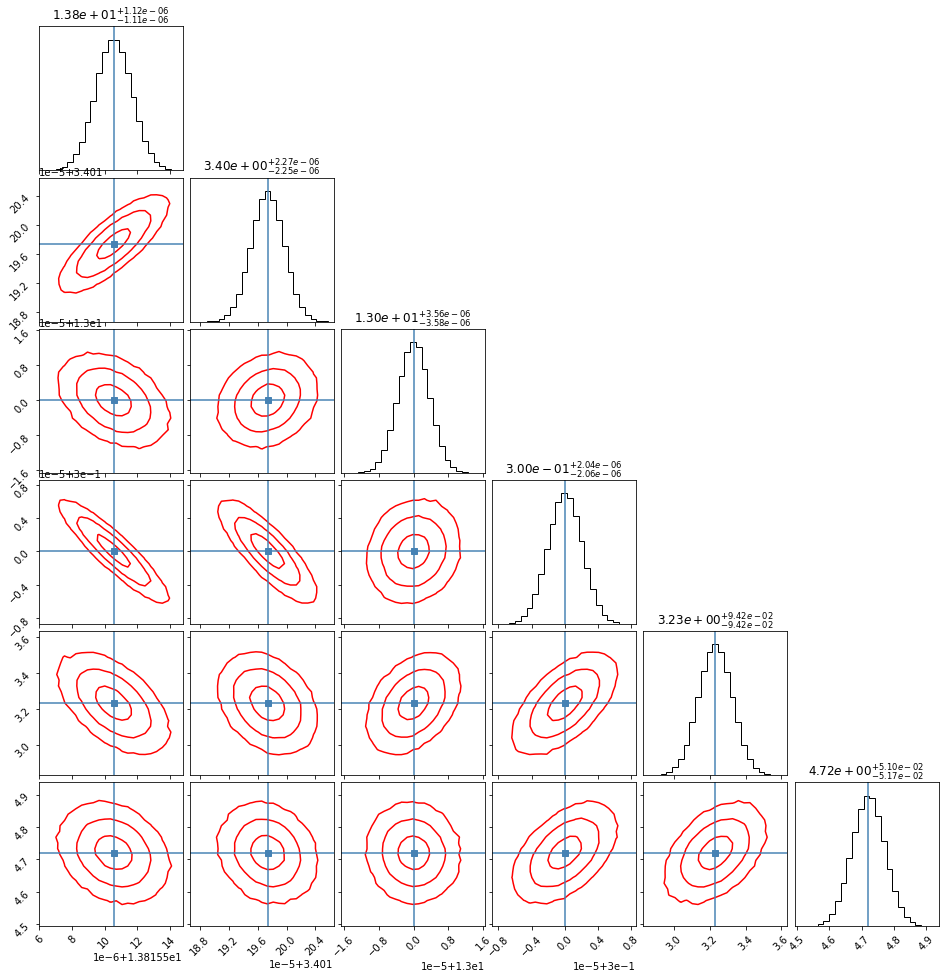

In [22]:
default_corner_kwargs = dict(
            levels=(1 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2)),
            bins=25,
            plot_density=False,
            plot_datapoints=False,
            smooth=0.4,
            contour_kwargs={"colors": "red"},
            hist_kwargs={"density": True},
            truths=injection_params[test_inds],
            show_titles=True,
            title_fmt=".2e",
        )

samp = np.random.multivariate_normal(injection_params[test_inds],cov,size=120000)


fig = corner.corner(samp,**default_corner_kwargs)

In [32]:
from lisatools.sampling.utility import ModifiedHDFBackend
filenames[ind_file]

'/Users/lorenzosperi/Nextcloud/AEI/FEW_paper/corner_data/output_2yr_snr_30_no_noise_3000000.0_30.0_0.1_1e-5.h5'

In [33]:
reader = ModifiedHDFBackend(filenames[ind_file])
chain = np.reshape(reader.get_chain(),(-1,6))
len(chain)
np.log(chain[:,1])

array([3.40119732, 3.40119744, 3.40119742, ..., 3.40117797, 3.40117024,
       3.40120109])

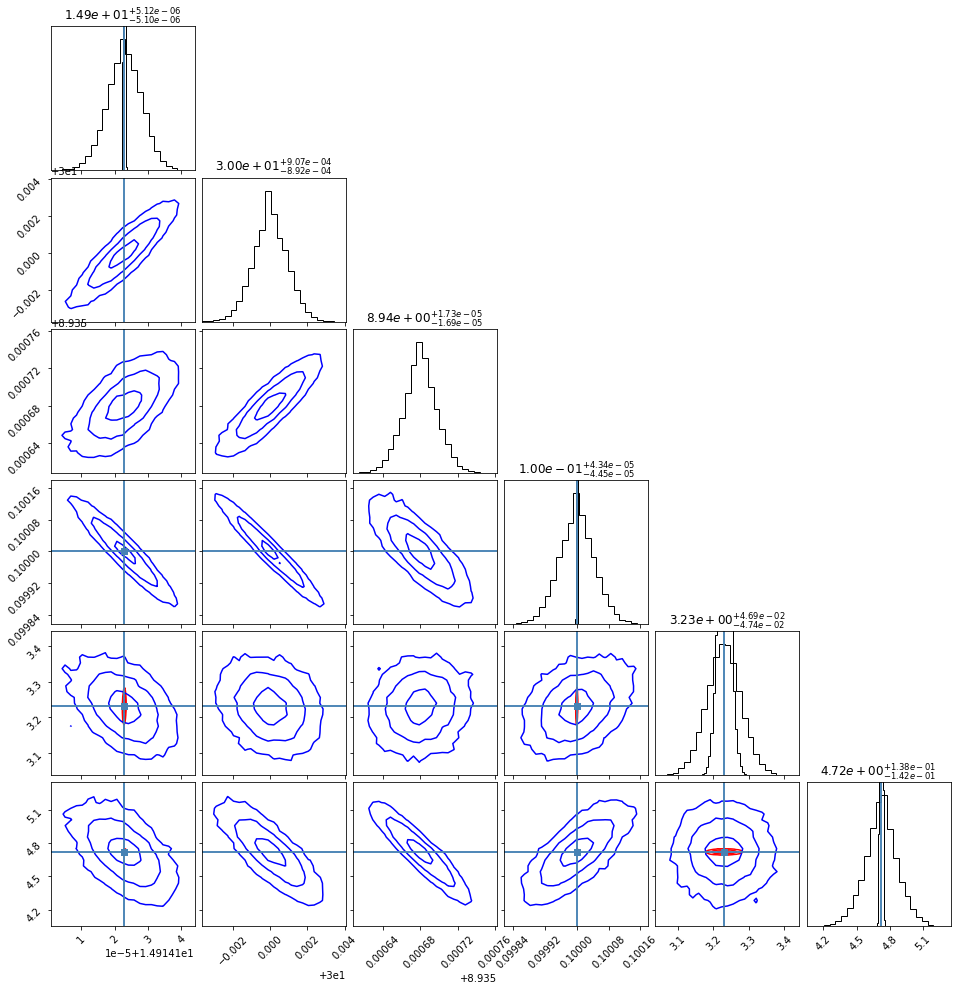

In [34]:
default_corner_kwargs = dict(
            levels=(1 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2)),
            bins=25,
            plot_density=False,
            plot_datapoints=False,
            smooth=0.4,
            contour_kwargs={"colors": "blue"},
            hist_kwargs={"density": True},
            truths=injection_params[test_inds],
            show_titles=True,
            title_fmt=".2e",
        )
corner.corner(chain,**default_corner_kwargs,fig=fig)

In [39]:
#cov = np.cov(chain.T)
fish = np.linalg.inv(np.cov(chain.T))


In [23]:

#print(inner_product(np.real(dh[0]),np.real(dh[0]),**inner_product_kwargs) + inner_product(np.imag(dh[0]),np.imag(dh[0]),**inner_product_kwargs), fish[0,0])
likelike = True
if likelike:

    ############################################
    #%% MCMC check

    # instantiate the likelihood class
    nchannels = 2
    like = Likelihood(
        fast, nchannels, dt=dt, parameter_transforms=transform_fn, use_gpu=use_gpu,
    )

    # inject
    like.inject_signal(
        params=injection_params.copy(),
        waveform_kwargs=waveform_kwargs,
        noise_fn=get_sensitivity,
        noise_kwargs=dict(sens_fn="cornish_lisa_psd"),
        add_noise=False,
    )

    # set kwargs for the templates
    waveform_kwargs_templates = waveform_kwargs.copy()
    #waveform_kwargs_templates["eps"] = 1e-2

    #%% Check inner product
    # single value likelihood
    like.get_ll(np.array([injection_params]),waveform_kwargs=waveform_kwargs)
    # copy again
    true_params = injection_params.copy()
    true_params = transform_fn.transform_base_parameters(true_params).T

    true_sig = fast(*true_params, **waveform_kwargs)

    Tick = ['$\log M$', '$\log \mu$', '$e$', '$p$']
    
    # only diag
    only_diag = True
    if only_diag:
        for i in range(len(test_inds)):

            j=1
            pert_params = injection_params.copy()
            pert_params[test_inds[i]] = pert_params[test_inds[i]] + j * fish[i,i]**(-0.5)
            p1 = np.exp(-like.get_ll(np.array([pert_params]),waveform_kwargs=waveform_kwargs))

            x = 1
            gaus = np.exp(-x*x/(2))
            print(p1,gaus)
    
    
    eig = True

    if eig:
        print("eig check")
        for j in range(len(cov)):
            for i in range(len(cov)):
                if i!=j:
                    

                    dev = np.array([ -2*fish[i,i]**(-0.5)*fish[i,j]/fish[j,j], fish[i,i]**(-0.5)])

                    pert_params = injection_params.copy()
                    pert_params[test_inds[j]] = pert_params[test_inds[j]] + dev[0]
                    pert_params[test_inds[i]] = pert_params[test_inds[i]] + dev[1]

                    p1 = (-like.get_ll(np.array([pert_params]),waveform_kwargs=waveform_kwargs)) # <d-h|d-h>

                    print(p1,-0.5)


[0.60618596] 0.6065306597126334
[0.6065144] 0.6065306597126334
[0.60729241] 0.6065306597126334
[0.60647221] 0.6065306597126334
[0.60655987] 0.6065306597126334
[0.60684403] 0.6065306597126334
eig check
[-0.49955995] -0.5
[-0.49884601] -0.5
[-0.49985603] -0.5
[-0.50079871] -0.5
[-0.50151333] -0.5
[-0.49758362] -0.5
[-0.49491179] -0.5
[-0.49738668] -0.5
[-0.49935618] -0.5
[-0.50026051] -0.5
[-0.49153563] -0.5
[-0.48983125] -0.5
[-0.49315327] -0.5
[-0.49675653] -0.5
[-0.49818349] -0.5
[-0.49739883] -0.5
[-0.4974222] -0.5
[-0.49806375] -0.5
[-0.50018078] -0.5
[-0.50116901] -0.5
[-0.50035139] -0.5
[-0.499317] -0.5
[-0.50238094] -0.5
[-0.50292303] -0.5
[-0.4996302] -0.5
[-0.49955186] -0.5
[-0.49970627] -0.5
[-0.4998449] -0.5
[-0.50148768] -0.5
[-0.49946573] -0.5
